# Testing of the Log Marginal Likelyhoods

- the LML can take on values below 0 which translates to a marginal likelyhood of above 1 which is possible since the marginal likelyhood is just the sum of the "probabilities" for observing each datapoint with the given distribution !!! That works because in the continuous case the densities can take values larger than one as long as the total integral evaluates to 1. And since the likelihood is proportional to a product of densities it can take values larger than 1 in the contiuous case.

In [1]:
import jax.numpy as jnp
from jax import random
import jax

from jaxgp.kernels import RBF
from jaxgp.likelihood import full_kernelNegativeLogLikelyhood, sparse_kernelNegativeLogLikelyhood

import matplotlib.pyplot as plt

In [2]:
def sin(x, noise=0.0, key = random.PRNGKey(0)):
    return jnp.sin(x) + random.normal(key,x.shape, dtype=jnp.float32)*noise

def cos(x, noise=0.0, key = random.PRNGKey(0)):
    return jnp.cos(x) + random.normal(key,x.shape, dtype=jnp.float32)*noise

In [3]:
def make_lml(params, num_params, mapping, grad_mapping):    
    nlle = []
    grad_nlle = []
    for param in params:
        nlle.append(mapping(param))
        grad_nlle.append(grad_mapping(param))

    nlle = jnp.array(nlle).reshape(num_params, num_params)
    grad_nlle = -jnp.array(grad_nlle)
    norm = jnp.linalg.norm(grad_nlle, axis=1)
    u = grad_nlle[:,0] / norm
    v = grad_nlle[:,1] / norm
    u = u.reshape(num_params, num_params)
    v = v.reshape(num_params, num_params)

    return nlle, u, v

def min_params(A, grid_x, grid_y):
    flat_ind = jnp.argmin(A)
    index = (flat_ind%len(grid_x), flat_ind//len(grid_y))
    return jnp.array([grid_x[index[0]], grid_y[index[1]]])

In [4]:
# Interval bounds from which to choose the data points
bounds = jnp.array([0.0, 2*jnp.pi])

# How many function and derivative observations should be chosen
num_f_vals = (1,)
num_d_vals = (10,)

# initial seed for the pseudo random key generation
seed = 0

# create new keys and randomly sample the above interval for training features
key, subkey = random.split(random.PRNGKey(seed))
x_func = random.uniform(subkey, num_f_vals, minval=bounds[0], maxval=bounds[1])
key, subkey = random.split(key)
x_der = random.uniform(subkey, num_d_vals, minval=bounds[0], maxval=bounds[1])

# noise with which to sample the training labels
noise = 0.05
key, subkey = random.split(key)
y_func = sin(x_func,noise, subkey)
key, subkey = random.split(key)
y_der = cos(x_der, noise, subkey)

# reshaping needs to be done the get the arrays in the form (n_samples_i, N)
X_split = [x_func.reshape(-1,1),x_der.reshape(-1,1)]
Y_train = jnp.hstack((y_func, y_der))

# num_vals = (10,)
# key, subkey = random.split(key)
# x_both = random.uniform(subkey, num_vals, minval=bounds[0], maxval=bounds[1])
# key, subkey = random.split(key)
# y_both = (sin(x_both,noise, subkey), cos(x_both, noise, subkey))
# X_split = [x_both.reshape(-1,1),x_both.reshape(-1,1)]
# Y_train = jnp.hstack(y_both)

kernel = RBF()

## Full likelihood

### 1D

In [5]:
param_bounds = jnp.array([0.2,4.0])
num_params = 40
grid = jnp.linspace(*param_bounds, num_params)
params = jnp.array(jnp.meshgrid(grid,grid)).reshape(2,-1).T

mapping = lambda x: jax.jit(full_kernelNegativeLogLikelyhood)(x, X_split, Y_train, noise, kernel)
grad_mapping = jax.jit(jax.grad(mapping))

In [6]:
nlle, u, v = make_lml(params, num_params, mapping, grad_mapping)

In [7]:
best_lbfgs = jnp.array([1.1177617, 2.0137794])
# best_lbfgs = jnp.array([1.6355635, 2.101072 ])
print(mapping(best_lbfgs))

best = min_params(nlle, grid, grid)
print(best)

-0.55429304
[1.1743591 2.0512822]


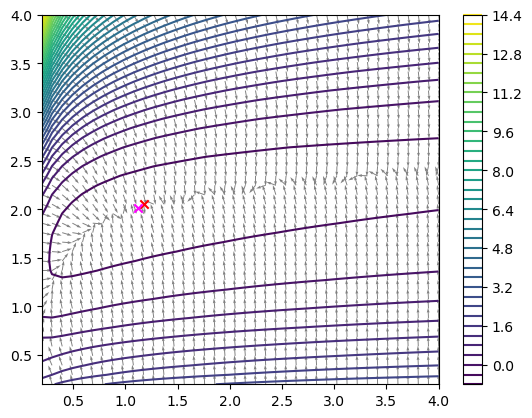

In [8]:
fig, ax = plt.subplots(1, 1)
im = ax.contour(grid, grid, nlle, 40)
ax.quiver(grid, grid, u, v, units='xy', scale=10.0, color='gray')
plt.colorbar(im, ax=ax)
plt.scatter(*best, c="red", marker="x")
plt.scatter(*best_lbfgs, c="magenta", marker="x")

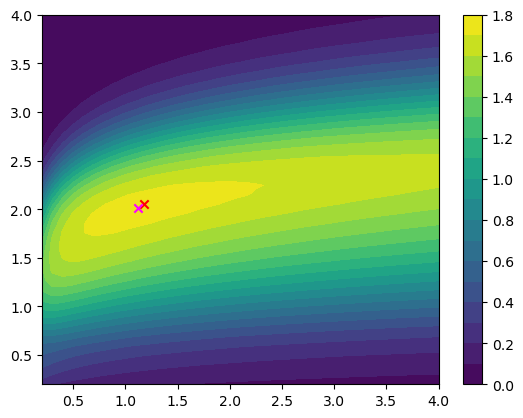

In [9]:
marg_likli = jnp.exp(-nlle)

plt.contourf(grid, grid, marg_likli, 20)
plt.colorbar()
plt.scatter(*best, c="red", marker="x")
plt.scatter(*best_lbfgs, c="magenta", marker="x")

### 2D

In [10]:
def fun(x, noise=0.0, key = random.PRNGKey(0)):
    return (x[:,0]**2 + x[:,1] - 11)**2 / 800.0 + (x[:,0] + x[:,1]**2 -7)**2 / 800.0 + random.normal(key,(len(x),), dtype=jnp.float32)*noise

def grad(x, noise=0.0, key = random.PRNGKey(0)):
    dx1 = 4 * (x[:,0]**2 + x[:,1] - 11) * x[:,0] + 2 * (x[:,0] + x[:,1]**2 -7)
    dx2 = 2 * (x[:,0]**2 + x[:,1] - 11) + 4 * (x[:,0] + x[:,1]**2 -7) * x[:,1]
    return jnp.vstack((dx1, dx2)).T / 800.0 + random.normal(key,x.shape, dtype=jnp.float32)*noise

To define the training data we first need to define boundaries to choose the datapoints from. Then, random points are chosen in this interval. `random.split` creates a new subkey from the previous key to get a new sudo-random sample from the uniform distribution.

In [11]:
# Interval bounds from which to choose the data points
bounds = jnp.array([-5.0, 5.0])

# How many function and derivative observations should be chosen
num_f_vals = 1
num_d_vals = 100

# initial seed for the pseudo random key generation
seed = 0

# create new keys and randomly sample the above interval for training features
key, subkey = random.split(random.PRNGKey(seed))
x_func = random.uniform(subkey, (num_f_vals, 2), minval=bounds[0], maxval=bounds[1])
key, subkey = random.split(key)
x_der = random.uniform(subkey, (num_d_vals,2), minval=bounds[0], maxval=bounds[1])

# noise with which to sample the training labels
noise = 0.02
key, subkey = random.split(key)
y_func = fun(x_func,noise, subkey)
key, subkey = random.split(key)
y_der = grad(x_der, noise, subkey)

X_split = [x_func,x_der]

Y_train = jnp.hstack((y_func, y_der.reshape(-1)))

kernel = RBF()

In [12]:
param_bounds_x = jnp.array([1.0,20.0])
param_bounds_y = jnp.array([0.2,10.0])
num_params = 40
grid_x = jnp.linspace(*param_bounds_x, num_params)
grid_y = jnp.linspace(*param_bounds_y, num_params)
params = jnp.array(jnp.meshgrid(grid_x,grid_x)).reshape(2,-1).T

mapping = lambda x: jax.jit(full_kernelNegativeLogLikelyhood)(x, X_split, Y_train, noise, kernel)
grad_mapping = jax.jit(jax.grad(mapping))

In [13]:
nlle, u, v = make_lml(params, num_params, mapping, grad_mapping)

In [14]:
best_lbfgs = jnp.array([1.1177617, 2.0137794])
# best_lbfgs = jnp.array([1.6355635, 2.101072 ])
print(mapping(best_lbfgs))

best = min_params(nlle, grid_x, grid_y)
print(best)

-1.6632588
[20.        3.215385]


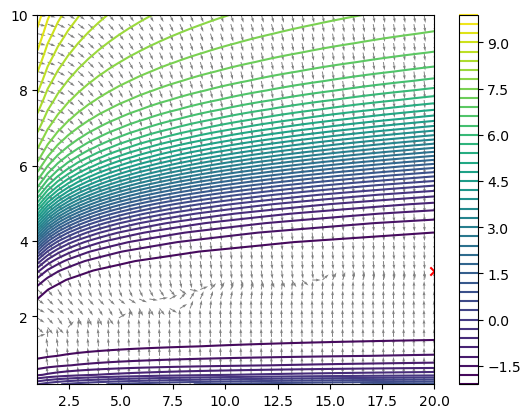

In [15]:
fig, ax = plt.subplots(1, 1)
im = ax.contour(grid_x, grid_y, nlle, 40)
ax.quiver(grid_x, grid_y, u, v, units='xy', scale=3.0, color='gray')
plt.colorbar(im, ax=ax)
plt.scatter(*best, c="red", marker="x")
# plt.scatter(*best_lbfgs, c="magenta", marker="x")

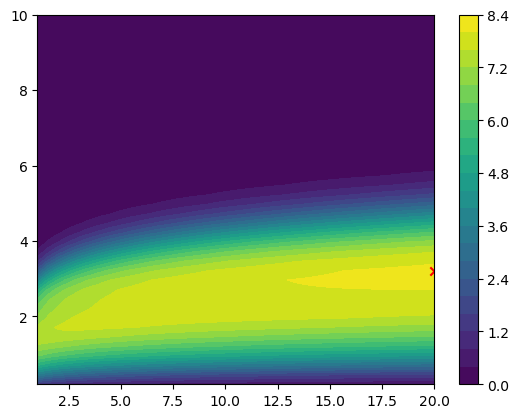

In [16]:
marg_likli = jnp.exp(-nlle)

plt.contourf(grid_x, grid_y, marg_likli, 20)
plt.colorbar()
plt.scatter(*best, c="red", marker="x")
# plt.scatter(*best_lbfgs, c="magenta", marker="x")

## Sparse likelihood with even and random grids

### 1D

In [17]:
num_ref_points = (3,)
key, subkey = random.split(key)
X_ref_rand = random.choice(subkey, x_der, num_ref_points).reshape(-1,1)
X_ref_even = jnp.linspace(*bounds, *num_ref_points).reshape(-1,1)

In [18]:
param_bounds = jnp.array([1e-3,4.0])
num_params = 40
grid = jnp.linspace(*param_bounds, num_params)
params = jnp.array(jnp.meshgrid(grid,grid)).reshape(2,-1).T

mapping_even = lambda x: jax.jit(sparse_kernelNegativeLogLikelyhood)(x, X_split, Y_train, X_ref_even, noise, kernel)
mapping_rand = lambda x: jax.jit(sparse_kernelNegativeLogLikelyhood)(x, X_split, Y_train, X_ref_rand, noise, kernel)
grad_mapping_even = jax.jit(jax.grad(mapping_even))
grad_mapping_rand = jax.jit(jax.grad(mapping_rand))

In [19]:
nlle_even, u_even, v_even = make_lml(params, num_params, mapping_even, grad_mapping_even)
nlle_rand, u_rand, v_rand = make_lml(params, num_params, mapping_rand, grad_mapping_rand)

In [20]:
best_lbfgs_even = jnp.array([0.356312, 0.871415])
best_lbfgs_rand = jnp.array([0.39525545, 0.92286205])

best_even = min_params(nlle_even, grid, grid)
best_rand = min_params(nlle_rand, grid, grid)
print(best_even, best_rand)

[0.10353846 2.2568462 ] [0.001      0.20607692]


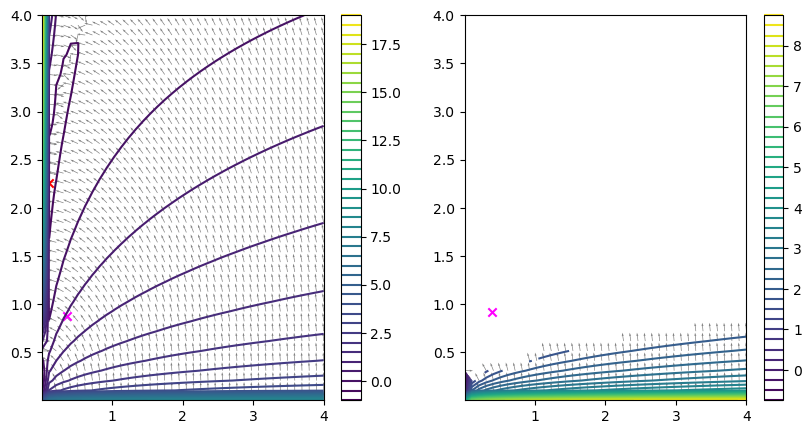

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
im = ax[0].contour(grid, grid, nlle_even, 40)
ax[0].quiver(grid, grid, u_even, v_even, units='xy', scale=10.0, color='gray')
plt.colorbar(im, ax=ax[0])
ax[0].scatter(*best_even, c="r", marker="x")
ax[0].scatter(*best_lbfgs_even, c="magenta", marker="x")


im = ax[1].contour(grid, grid, nlle_rand, 40)
ax[1].quiver(grid, grid, u_rand, v_rand, units='xy', scale=10.0, color='gray')
plt.colorbar(im, ax=ax[1])
ax[1].scatter(*best_rand, c="r", marker="x")
ax[1].scatter(*best_lbfgs_rand, c="magenta", marker="x")

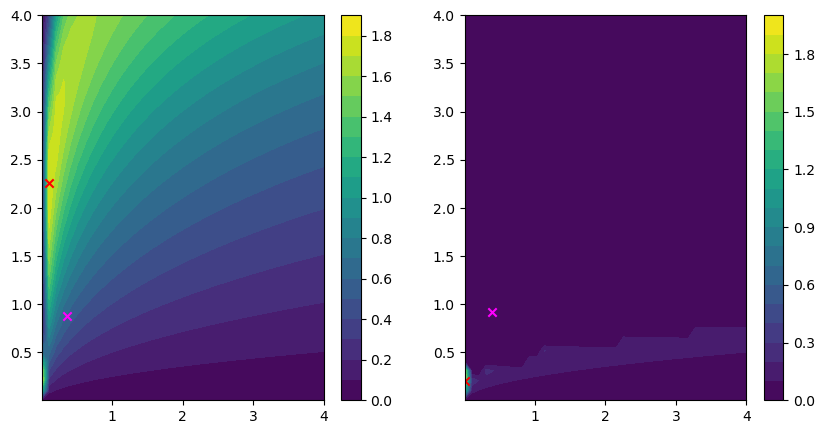

In [22]:
marg_likli_even = jnp.exp(-nlle_even)
marg_likli_rand = jnp.exp(-nlle_rand)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
im = ax[0].contourf(grid, grid, marg_likli_even, 20)
ax[0].scatter(*best_even, c="r", marker="x")
ax[0].scatter(*best_lbfgs_even, c="magenta", marker="x")
plt.colorbar(im, ax=ax[0])
im = ax[1].contourf(grid, grid, marg_likli_rand, 20)
plt.colorbar(im, ax=ax[1])
ax[1].scatter(*best_rand, c="r", marker="x")
ax[1].scatter(*best_lbfgs_rand, c="magenta", marker="x")

### 2D

In [23]:
def fun(x, noise=0.0, key = random.PRNGKey(0)):
    return (x[:,0]**2 + x[:,1] - 11)**2 / 800.0 + (x[:,0] + x[:,1]**2 -7)**2 / 800.0 + random.normal(key,(len(x),), dtype=jnp.float32)*noise

def grad(x, noise=0.0, key = random.PRNGKey(0)):
    dx1 = 4 * (x[:,0]**2 + x[:,1] - 11) * x[:,0] + 2 * (x[:,0] + x[:,1]**2 -7)
    dx2 = 2 * (x[:,0]**2 + x[:,1] - 11) + 4 * (x[:,0] + x[:,1]**2 -7) * x[:,1]
    return jnp.vstack((dx1, dx2)).T / 800.0 + random.normal(key,x.shape, dtype=jnp.float32)*noise

To define the training data we first need to define boundaries to choose the datapoints from. Then, random points are chosen in this interval. `random.split` creates a new subkey from the previous key to get a new sudo-random sample from the uniform distribution.

In [24]:
# Interval bounds from which to choose the data points
bounds = jnp.array([-5.0, 5.0])

# How many function and derivative observations should be chosen
num_f_vals = 1
num_d_vals = 1000

# initial seed for the pseudo random key generation
seed = 0

# create new keys and randomly sample the above interval for training features
key, subkey = random.split(random.PRNGKey(seed))
x_func = random.uniform(subkey, (num_f_vals, 2), minval=bounds[0], maxval=bounds[1])
key, subkey = random.split(key)
x_der = random.uniform(subkey, (num_d_vals,2), minval=bounds[0], maxval=bounds[1])

# noise with which to sample the training labels
noise = 0.02
key, subkey = random.split(key)
y_func = fun(x_func,noise, subkey)
key, subkey = random.split(key)
y_der = grad(x_der, noise, subkey)

X_split = [x_func,x_der]

Y_train = jnp.hstack((y_func, y_der.reshape(-1)))

kernel = RBF()

In [25]:
num_ref_points = (100,)
key, subkey = random.split(key)
X_ref_rand = random.choice(subkey, x_der, num_ref_points).reshape(-1,1)
X_ref_even = jnp.linspace(*bounds, *num_ref_points).reshape(-1,1)

In [26]:
param_bounds_x = jnp.array([1.0,20.0])
param_bounds_y = jnp.array([0.2,10.0])
num_params = 40
grid_x = jnp.linspace(*param_bounds_x, num_params)
grid_y = jnp.linspace(*param_bounds_y, num_params)
params = jnp.array(jnp.meshgrid(grid_x,grid_x)).reshape(2,-1).T

mapping_even = lambda x: jax.jit(sparse_kernelNegativeLogLikelyhood)(x, X_split, Y_train, X_ref_even, noise, kernel)
mapping_rand = lambda x: jax.jit(sparse_kernelNegativeLogLikelyhood)(x, X_split, Y_train, X_ref_rand, noise, kernel)
grad_mapping_even = jax.jit(jax.grad(mapping_even))
grad_mapping_rand = jax.jit(jax.grad(mapping_rand))

In [27]:
nlle_even, u_even, v_even = make_lml(params, num_params, mapping_even, grad_mapping_even)
nlle_rand, u_rand, v_rand = make_lml(params, num_params, mapping_rand, grad_mapping_rand)

In [28]:
best_lbfgs_even = jnp.array([0.356312, 0.871415])
best_lbfgs_rand = jnp.array([0.39525545, 0.92286205])

best_even = min_params(nlle_even, grid, grid)
best_rand = min_params(nlle_rand, grid, grid)
print(best_even, best_rand)

[0.001 0.001] [0.001 0.001]


/home/lukas/miniconda3/envs/gpr/lib/python3.9/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/lukas/miniconda3/envs/gpr/lib/python3.9/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


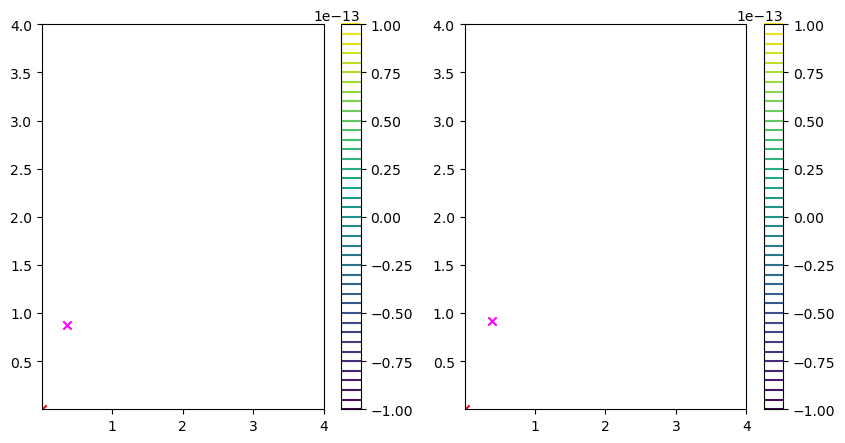

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
im = ax[0].contour(grid, grid, nlle_even, 40)
ax[0].quiver(grid, grid, u_even, v_even, units='xy', scale=10.0, color='gray')
plt.colorbar(im, ax=ax[0])
ax[0].scatter(*best_even, c="r", marker="x")
ax[0].scatter(*best_lbfgs_even, c="magenta", marker="x")


im = ax[1].contour(grid, grid, nlle_rand, 40)
ax[1].quiver(grid, grid, u_rand, v_rand, units='xy', scale=10.0, color='gray')
plt.colorbar(im, ax=ax[1])
ax[1].scatter(*best_rand, c="r", marker="x")
ax[1].scatter(*best_lbfgs_rand, c="magenta", marker="x")

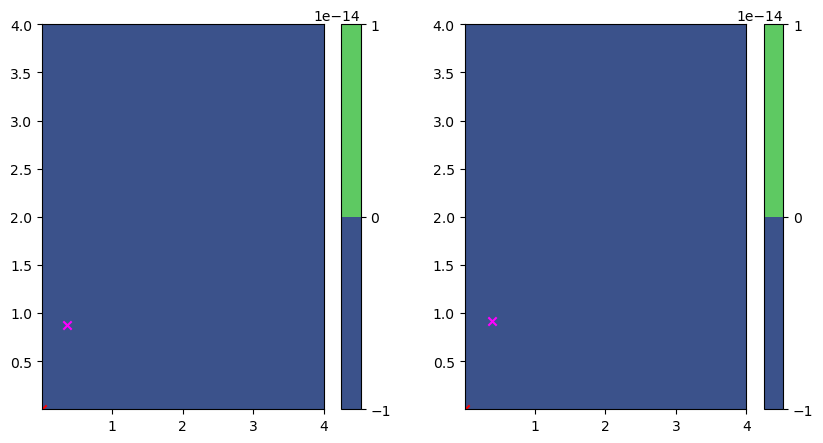

In [30]:
marg_likli_even = jnp.exp(-nlle_even)
marg_likli_rand = jnp.exp(-nlle_rand)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
im = ax[0].contourf(grid, grid, marg_likli_even, 20)
ax[0].scatter(*best_even, c="r", marker="x")
ax[0].scatter(*best_lbfgs_even, c="magenta", marker="x")
plt.colorbar(im, ax=ax[0])
im = ax[1].contourf(grid, grid, marg_likli_rand, 20)
plt.colorbar(im, ax=ax[1])
ax[1].scatter(*best_rand, c="r", marker="x")
ax[1].scatter(*best_lbfgs_rand, c="magenta", marker="x")